Analyze whether large whale transfers (> $100K) precede or correlate with significant price movements of a token.
### 1. Select Token & Timeframe  
- Choose a token (e.g., ETH)  
- Define a time range (e.g., last 30 days)
### 2. Fetch Price Data  
- Request historical price data  
- Convert to DataFrame with timestamps and prices
### 3. Fetch Whale Transfer Data  
- Request large transfer transactions (Dune Query)
- Convert to DataFrame with timestamps, amounts, and USD values
### 4. Preprocess Data  
- Convert timestamps to datetime  
- Resample both datasets to the same interval (daily/hourly)  
- Aggregate whale metrics per interval (transfer count, total volume)
### 5. Merge Datasets  
- Join price and whale activity data on timestamp  
- Ensure aligned intervals and no missing values
### 6. Analyze Correlation  
- Calculate percent price change   
- Compute correlation between whale activity and price movement
### 7. Visualize  
- Dual-axis line plots: price vs whale activity  
- Scatter Plots: price change (%) vs whale activity


In [ ]:
import os
from dotenv import load_dotenv
import requests
import pandas as pd
from dune_client.client import DuneClient
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker



load_dotenv()

GECKO_API = os.getenv('GECKO_API')
DUNE_API = os.getenv('DUNE_API')

coingecko_url = 'https://api.coingecko.com/api/v3' 

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": GECKO_API
}


### Fetch 30-day daily price data for Ethereum


In [63]:
params = {
    'vs_currency': 'usd',
    'days': '30',
    'interval': 'daily'
}

# Send GET request
response = requests.get(coingecko_url + '/coins/ethereum/market_chart', params=params, headers=headers)

# Convert JSON to DataFrame
data = response.json()
prices = data['prices']  # List of [timestamp, price]

# Convert to DataFrame
df_price = pd.DataFrame(prices, columns=['timestamp', 'price'])

# Convert timestamp to readable datetime
df_price['timestamp'] = pd.to_datetime(df_price['timestamp'], unit='ms')
df_price['timestamp'] = df_price['timestamp'].dt.floor('D')  # normalize to day
df_price = df_price.groupby('timestamp', as_index=False).first()  # get just the first price of the current day


# df_price

### Fetch Whale Transfers

In [62]:


dune_url = "https://api.dune.com/api/v1/query/5591956/results"

headers = {"X-DUNE-API-KEY": DUNE_API}

response = requests.get(dune_url, headers=headers)

# Output the result in JSON format
result_json = response.json()

rows = result_json.get("result", {}).get("rows", [])

df_whale = pd.DataFrame(rows, columns=["date", "amount", "transactions", "whales"])

df_whale.rename(columns={"date": "timestamp"}, inplace=True)

df_whale['timestamp'] = pd.to_datetime(df_whale["timestamp"], format='%Y-%m-%d')


# df_whale

### Merge DataSet

In [64]:
combined_dataframe = df_price.merge(df_whale, on='timestamp', how='outer')

# print(combined_dataframe)

### Relationship between price and whale transfer amounts

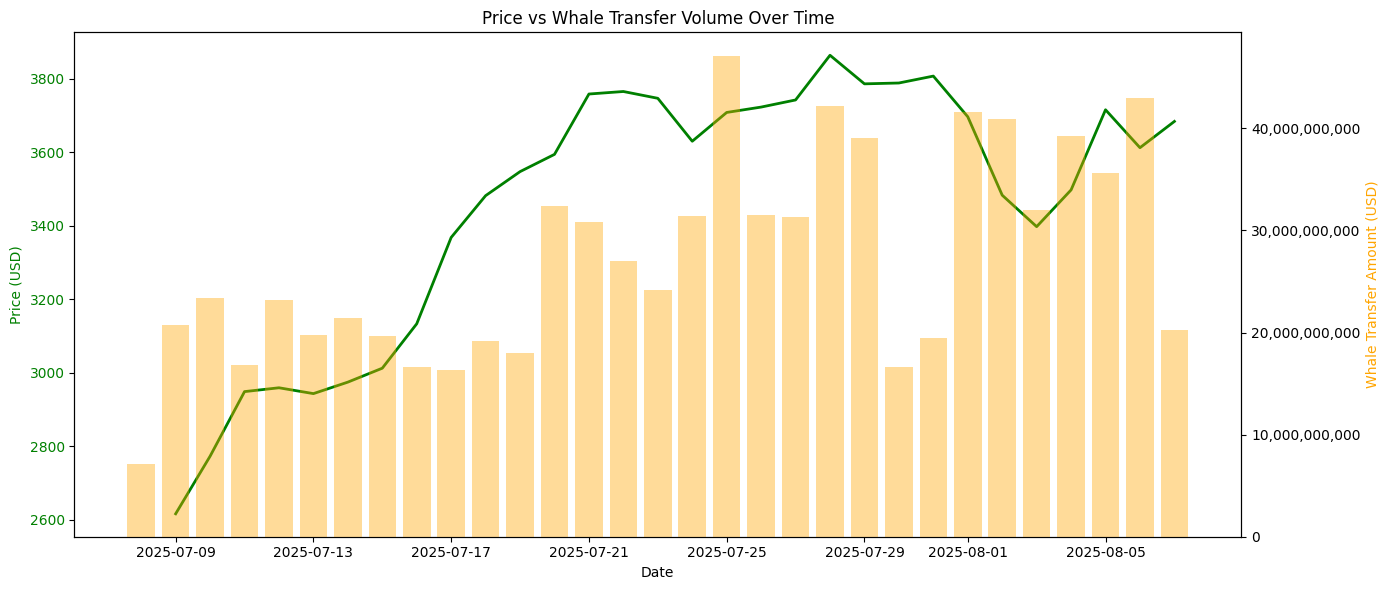

In [ ]:
# Ensure timestamp is sorted
combined_dataframe.sort_values('timestamp', inplace=True)

# Set up the figure and two y-axes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot price on left Y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)', color='green')
ax1.plot(combined_dataframe['timestamp'], combined_dataframe['price'], color='green', linewidth=2, label='Price')
ax1.tick_params(axis='y', labelcolor='green')

# Create a second y-axis for whale transfer amount
ax2 = ax1.twinx()
ax2.set_ylabel('Whale Transfer Amount (USD)', color='orange')

# Plot whale transfer amount as bars
ax2.bar(combined_dataframe['timestamp'], combined_dataframe['amount'], color='orange', alpha=0.4, label='Whale Transfers')

# Format Y-axis with full numbers
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.title('Price vs Whale Transfer Volume Over Time')
fig.tight_layout()

# Show the plot
plt.show()

### Correlation between Whale Transfers vs Daily Price Change

Correlation between daily whale transfers (amount) and price change: -0.3894
P-value: 0.0368


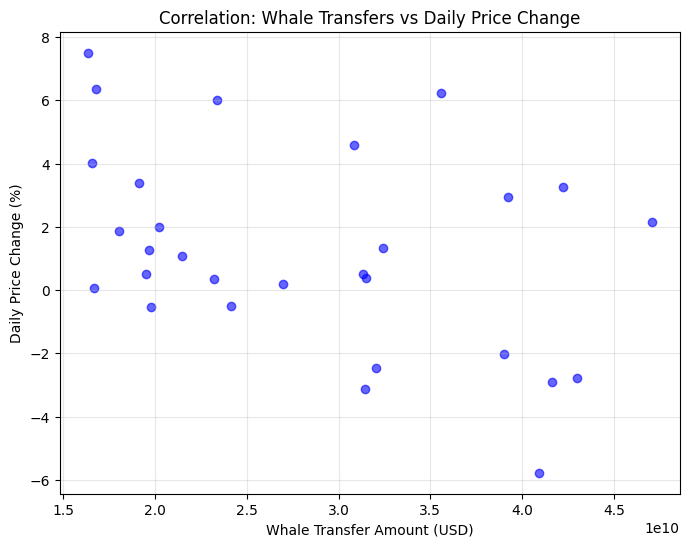

In [ ]:
# Calculate daily percent price change
if 'price_change_pct' not in combined_dataframe.columns:
    combined_dataframe['price_change_pct'] = combined_dataframe['price'].pct_change(
    ) * 100

# Drop missing values for correlation plot
df_corr = combined_dataframe[['amount', 'price_change_pct']].dropna()

# Calculate Pearson correlation
corr, pval = pearsonr(df_corr['amount'], df_corr['price_change_pct'])

plt.figure(figsize=(8, 6))
plt.scatter(df_corr['amount'], df_corr['price_change_pct'], alpha=0.6, color='blue')
plt.xlabel('Whale Transfer Amount (USD)')
plt.ylabel('Daily Price Change (%)')
plt.title('Correlation: Whale Transfers vs Daily Price Change')
plt.grid(True, alpha=0.3)

### Correlation between Transfer Amount, No. of Transactions, No. of Whales and Price Change (%) 

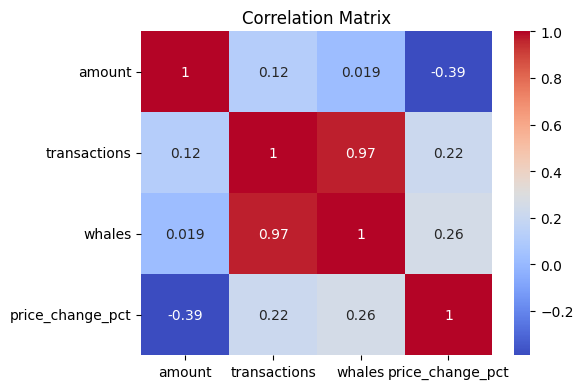

In [ ]:
import seaborn as sns

metrics = combined_dataframe[['amount', 'transactions', 'whales', 'price_change_pct']].dropna()

corr_matrix = metrics.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()